In [127]:
import os
import shap
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, log_loss,confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
warnings.filterwarnings('ignore')

In [128]:
# from sklearn.exceptions import ConvergenceWarning
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore", category=ConvergenceWarning)

In [129]:
df_school = pd.read_csv('../dataset/dataset.csv')

In [130]:
df_school['Target'].unique()

array(['Dropout', 'Graduate', 'Enrolled'], dtype=object)

In [131]:
df_school['Target'] = np.where(df_school['Target'] == 'Dropout', 'YES', 'NO')
df_school['Target'] = df_school['Target'].apply(lambda x: 1 if x == 'YES' else 0)

In [132]:
numeric_columns = list(set(df_school.select_dtypes(include='number').columns))
categorical_columns = list(set(df_school.select_dtypes(exclude='number').columns))
print(f"There are {len(numeric_columns)} numeric columns: {numeric_columns}")

There are 35 numeric columns: ['Curricular units 2nd sem (enrolled)', 'GDP', 'Tuition fees up to date', 'Curricular units 1st sem (evaluations)', 'Nacionality', 'Age at enrollment', "Mother's qualification", 'Displaced', "Father's occupation", 'Curricular units 2nd sem (credited)', 'Previous qualification', 'Educational special needs', 'Curricular units 1st sem (without evaluations)', 'Unemployment rate', 'Application mode', 'Curricular units 1st sem (credited)', 'Scholarship holder', "Mother's occupation", 'Gender', 'Marital status', 'Daytime/evening attendance', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', "Father's qualification", 'Inflation rate', 'Curricular units 2nd sem (grade)', 'Course', 'Curricular units 2nd sem (without evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (enrolled)', 'Target', 'Application order', 'International', 'Debtor', 'Curricular units 1st sem (grade)']


#### Select features and target

In [133]:
y=df_school['Target']
X=df_school.iloc[:,:-1]

#### Feature Importance and selection

In [134]:
clf = RandomForestClassifier()
clf = clf.fit(X, y)
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
selected_features = X.columns[model.get_support()]
print(f'The most important features from the RF Classifier are: {selected_features}')

The most important features from the RF Classifier are: Index(['Course', 'Father's occupation', 'Tuition fees up to date',
       'Age at enrollment', 'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)'],
      dtype='object')


#### Training the Model with Logistic Regression

In [135]:
X = df_school[selected_features]
sensitive_attribute = df_school[['Marital status', 'Nacionality', 'Gender']]
X_train, X_test, y_train, y_test, sens_train, sens_test = train_test_split(X, y,sensitive_attribute, test_size=0.2, random_state=1)
logistic_model = LogisticRegression()
logistic_model.fit(X_train,y_train )
y_predictions = logistic_model.predict(X_test)
print(f'Model accuracy {round(accuracy_score(y_predictions, y_test), 2)}')
print(f'Model F1score {round(f1_score(y_predictions, y_test), 2)}')
print(f'Model Recall {round(recall_score(y_predictions, y_test), 2)} and precision {round(precision_score(y_predictions, y_test), 2)}')


Model accuracy 0.86
Model F1score 0.75
Model Recall 0.84 and precision 0.68


In [136]:
def plot_confusions(ytest, ypred):
    cm = confusion_matrix(y_test, ypred)
    plt.figure(figsize=(4, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

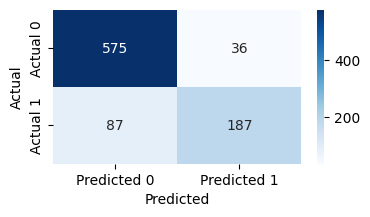

In [137]:
plot_confusions(y_test, y_predictions)

### Model Explanation Using Shap

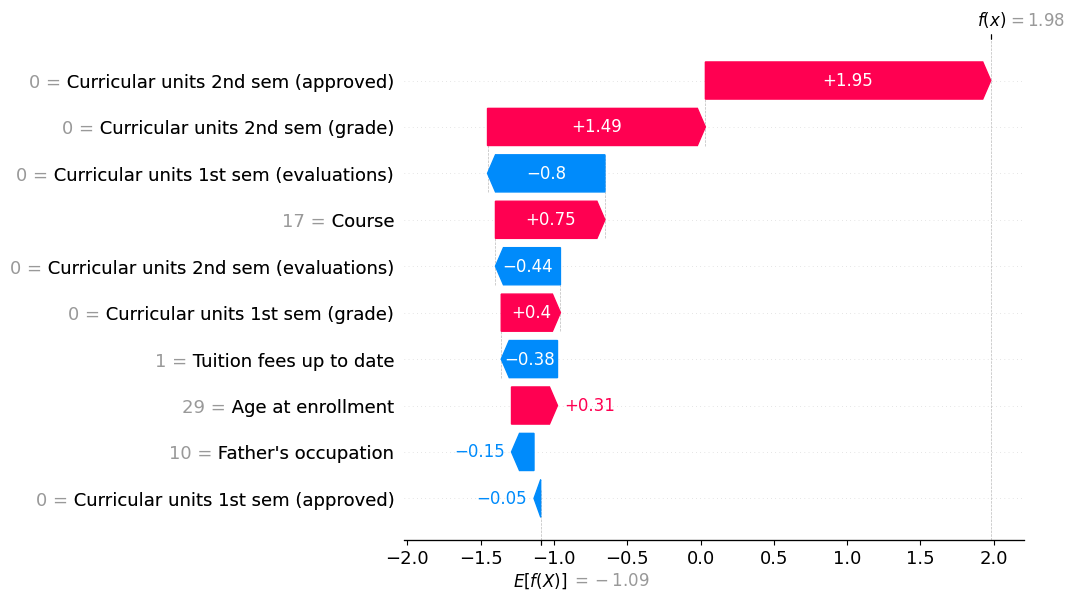

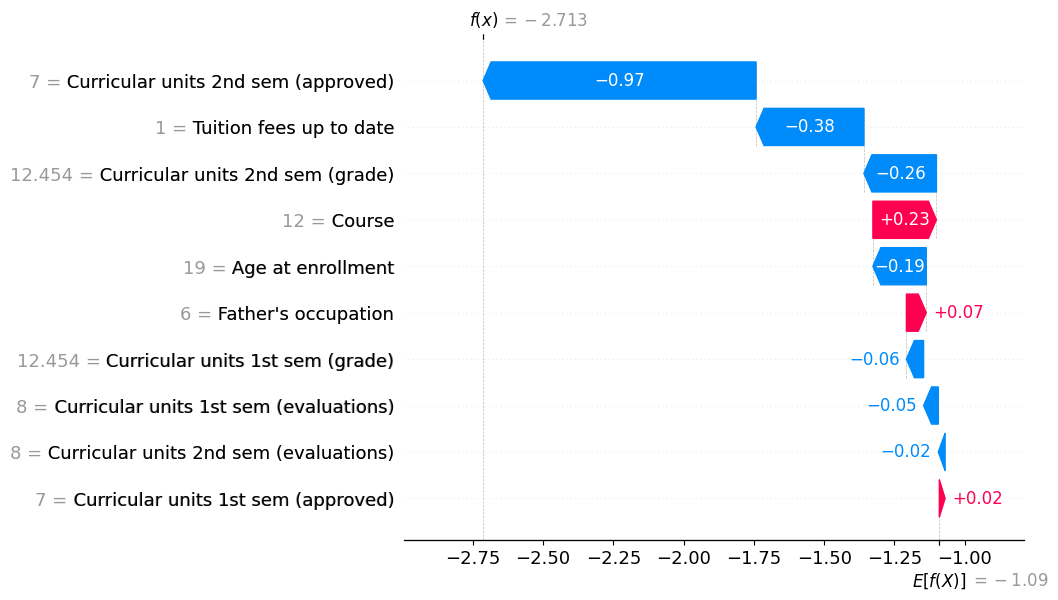

In [138]:
explainer = shap.Explainer(logistic_model, X_train)
shap_values = explainer(X_test)

# # For the positive class (usually coded as 1)
shap.plots.waterfall(shap_values[0])

# # For the negative class (usually coded as 0)
shap.plots.waterfall(shap_values[1])

### Model Performance across groups for fairness

In [139]:
fairX = X_test.copy()
fairX['ytest'] = y_test
fairX['predictions'] = y_predictions
fairX['Gender'] = sens_test['Gender']
female_df= fairX[fairX.Gender==0]
male_df= fairX[fairX.Gender==1]

In [140]:
print("Accuracy Score for females: ",round(accuracy_score(female_df.ytest, female_df.predictions), 2))
print("Precision Score for females: ", round(precision_score(female_df.ytest, female_df.predictions),2 ))
print("Recall Score for females: ", round(recall_score(female_df.ytest, female_df.predictions), 2))
print("F1 Score for females: ", round(f1_score(female_df.ytest, female_df.predictions), 2))

Accuracy Score for females:  0.89
Precision Score for females:  0.86
Recall Score for females:  0.66
F1 Score for females:  0.75


In [141]:
print("Accuracy Score for males: ", round(accuracy_score(male_df.ytest, male_df.predictions), 2))
print("Precision Score for males: ", round(precision_score(male_df.ytest, male_df.predictions),2))
print("Recall Score for males: ", round(recall_score(male_df.ytest, male_df.predictions),2))
print("F1 Score for males: ", round(f1_score(male_df.ytest, male_df.predictions),2))

Accuracy Score for males:  0.79
Precision Score for males:  0.81
Recall Score for males:  0.71
F1 Score for males:  0.76


In [142]:
fairX['Age_Group'] = fairX['Age at enrollment'].apply(lambda age: 0 if age > 22 else 1) # old: 0, young:1

In [143]:
round(accuracy_score(fairX[fairX['Age_Group']==0]['ytest'], fairX[fairX['Age_Group']==0]['predictions']),2)

0.85

In [144]:
round(accuracy_score(fairX[fairX['Age_Group']==1]['ytest'], fairX[fairX['Age_Group']==1]['predictions']),2)

0.87

## Demographic Parity

In [145]:
import torch
import texttable as tt
def statistical_parity(y_pred, mask):
    if isinstance(mask, torch.Tensor):
        mask = mask.numpy()
    y_cond = y_pred * mask.astype(np.float32)
    return y_cond.sum() / mask.sum()

### Equality of opportunity

In [146]:
def equal_opportunity(y_pred, y, mask):
    if isinstance(mask, np.ndarray):
        mask = torch.tensor(mask)
    y_cond = y * y_pred * mask.float()  
    return y_cond.sum() / (y * mask.float()).sum() 

### Test Error

In [147]:
def test_error(y_pred,y_true):
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.numpy()
        y_true = y_true.numpy()
    return np.mean(y_pred!=y_true)

### Confusion Matrix

In [148]:
def confusion_matrix(y_pred, y_true, mask=None):
    y_pred = torch.tensor(y_pred)
    y_true = torch.tensor(y_true)
    size = y_true.size(0) if mask is None else mask.sum().item()
    sum_and_int = lambda x: x.sum().long().item()
    to_percentage = lambda l: [f'{float(y)* 100. / size :.2f}%' for y in l]
    y_pred_binary = (y_pred > 0.5).float()
    if mask is None:
        mask = torch.ones_like(y_pred)  
    if isinstance(mask, np.ndarray):
        mask = torch.tensor(mask)
    mask = mask.float()
    true_positives = sum_and_int(y_true * y_pred_binary * mask)
    false_positives = sum_and_int((1 - y_true) * y_pred_binary * mask)
    true_negatives = sum_and_int((1 - y_true) * (1 - y_pred_binary) * mask)
    false_negatives = sum_and_int(y_true * (1 - y_pred_binary) * mask)
    total = true_positives + false_positives + true_negatives + false_negatives
    table = tt.Texttable()
    table.header(['Real/Pred', 'Positive', 'Negative', ''])
    table.add_row(['Positive'] + to_percentage([true_positives, false_negatives, true_positives + false_negatives]))
    table.add_row(['Negative'] + to_percentage([false_positives, true_negatives, false_positives + true_negatives]))
    table.add_row([''] + to_percentage([true_positives + false_positives, false_negatives + true_negatives, total]))
    
    return table

In [149]:
def get_statistics(model, X_test, y_test, pred, mask, confusion=True):
    print(f"Test error is {round(test_error(pred,y_test), 2)} and accuracy is {round(1-test_error(pred,y_test),2)} ")
    if confusion == True:
        print("Confusion matrix all: ")
        print(confusion_matrix(pred,y_test).draw())
        print("Confusion matrix unprotected: ")
        print(confusion_matrix(pred,y_test,mask).draw())
        print("Confusion matrix protected: ")
        print(confusion_matrix(pred,y_test,1-mask).draw())
    pred = torch.tensor(pred)
    y_test = torch.tensor(y_test)
    print("statistical_parity for unprotected: %.3f, for protected: %.3f, difference: %.3f" % (statistical_parity(pred, mask),statistical_parity(pred,1-mask), statistical_parity(pred,mask)-statistical_parity(pred,1-mask)))
    print("equal_opportunity for unprotected: %.3f, for protected: %.3f, difference: %.3f" % (equal_opportunity(pred, y_test,mask),equal_opportunity(pred, y_test,1-mask), equal_opportunity(pred, y_test,mask) - equal_opportunity(pred, y_test,1-mask)))

In [150]:
mask = fairX.Age_Group
get_statistics(logistic_model, X_test, y_test.values, fairX.predictions.values, mask.values, confusion=True)

Test error is 0.14 and accuracy is 0.86 
Confusion matrix all: 
+-----------+----------+----------+---------+
| Real/Pred | Positive | Negative |         |
+===========+==========+==========+=========+
| Positive  | 21.13%   | 9.83%    | 30.96%  |
+-----------+----------+----------+---------+
| Negative  | 4.07%    | 64.97%   | 69.04%  |
+-----------+----------+----------+---------+
|           | 25.20%   | 74.80%   | 100.00% |
+-----------+----------+----------+---------+
Confusion matrix unprotected: 
+-----------+----------+----------+---------+
| Real/Pred | Positive | Negative |         |
+===========+==========+==========+=========+
| Positive  | 13.13%   | 9.65%    | 22.78%  |
+-----------+----------+----------+---------+
| Negative  | 3.80%    | 73.42%   | 77.22%  |
+-----------+----------+----------+---------+
|           | 16.93%   | 83.07%   | 100.00% |
+-----------+----------+----------+---------+
Confusion matrix protected: 
+-----------+----------+----------+---------+
| 

In [151]:
mask_gender = fairX.Gender
get_statistics(logistic_model, X_test, y_test.values, fairX.predictions.values, mask_gender.values, confusion=True)

Test error is 0.14 and accuracy is 0.86 
Confusion matrix all: 
+-----------+----------+----------+---------+
| Real/Pred | Positive | Negative |         |
+===========+==========+==========+=========+
| Positive  | 21.13%   | 9.83%    | 30.96%  |
+-----------+----------+----------+---------+
| Negative  | 4.07%    | 64.97%   | 69.04%  |
+-----------+----------+----------+---------+
|           | 25.20%   | 74.80%   | 100.00% |
+-----------+----------+----------+---------+
Confusion matrix unprotected: 
+-----------+----------+----------+---------+
| Real/Pred | Positive | Negative |         |
+===========+==========+==========+=========+
| Positive  | 32.28%   | 13.33%   | 45.61%  |
+-----------+----------+----------+---------+
| Negative  | 7.37%    | 47.02%   | 54.39%  |
+-----------+----------+----------+---------+
|           | 39.65%   | 60.35%   | 100.00% |
+-----------+----------+----------+---------+
Confusion matrix protected: 
+-----------+----------+----------+---------+
| 

# Training an Unaware classifier

In [152]:
# unaware_X = X.drop('Curricular units 2nd sem (approved)', axis=1)
unaware_X = X.drop('Age at enrollment', axis=1)

# unaware_X.head()

In [153]:
unaware_Xtrain, unaware_Xtest, unaware_ytrain, unaware_ytest, unaware_senstrain, unaware_senstest = train_test_split(unaware_X, y, sensitive_attribute, test_size=0.2, random_state=1)
unaware_LRmodel = LogisticRegression()
unaware_LRmodel.fit(unaware_Xtrain, unaware_ytrain )
unaware_ypredictions = unaware_LRmodel.predict(unaware_Xtest)
print(f'Model accuracy {round(accuracy_score(unaware_ypredictions, unaware_ytest), 2)}')
print(f'Model F1score {round(f1_score(unaware_ypredictions, unaware_ytest), 2)}')
print(f'Model Recall {round(recall_score(unaware_ypredictions, unaware_ytest), 2)} and precision {round(precision_score(unaware_ypredictions, unaware_ytest), 2)}')

Model accuracy 0.86
Model F1score 0.75
Model Recall 0.81 and precision 0.7


In [154]:
fairX['Gender'].value_counts()

Gender
0    600
1    285
Name: count, dtype: int64

In [155]:
fairX['Age_Group'] = fairX['Age_Group'].apply(lambda age: 'old' if age ==0 else 'young') # old: 0, young:1
fairX['Gender'] = fairX['Gender'].apply(lambda gender: 'Males' if gender == 0 else 'Females') # old: 0, young:1

# fairX['Age_Group']

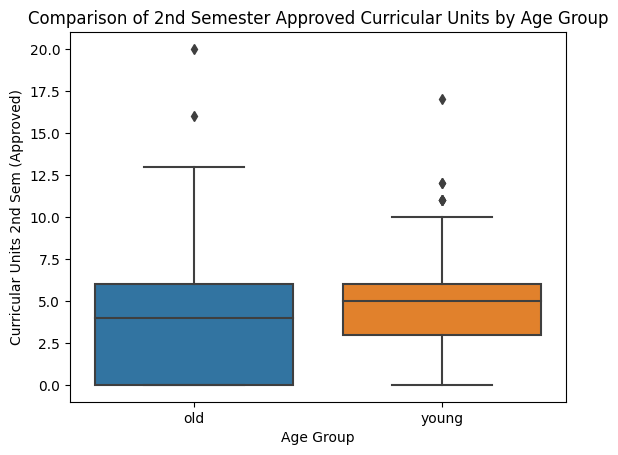

In [156]:
#0:old, 1:young

sns.boxplot(x='Age_Group', y='Curricular units 2nd sem (approved)', data=fairX)
plt.title('Comparison of 2nd Semester Approved Curricular Units by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Curricular Units 2nd Sem (Approved)')
plt.show()

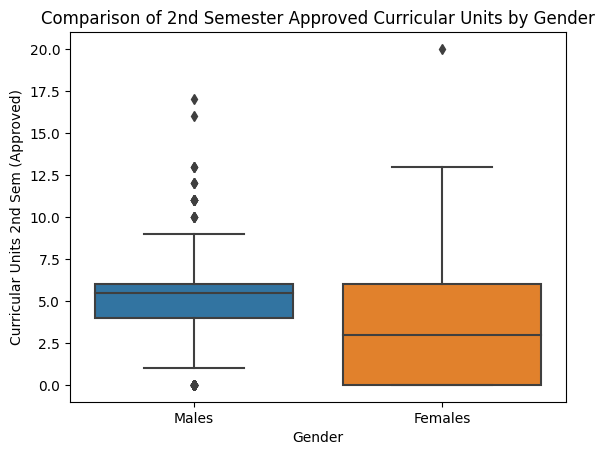

In [157]:
sns.boxplot(x='Gender', y='Curricular units 2nd sem (approved)', data=fairX)
plt.title('Comparison of 2nd Semester Approved Curricular Units by Gender')
plt.xlabel('Gender')
plt.ylabel('Curricular Units 2nd Sem (Approved)')
plt.show()